In [4]:
import numpy as np
import torch
import os
import random
from numpy.linalg import eigh, norm

# ===== 1. 固定随机种子 =====
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# ===== 2. 高维配置参数 =====
n = 1000                  # 样本数
p = 2                    # 子空间维度
alpha = 1.4
d = int(n / alpha)       # 特征维度
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # 打印当前设备

# ===== 3. 数据生成 =====
def generate_data(n, d, p):
    W_star = np.random.randn(d, p)
    X = np.random.randn(n, d) / np.sqrt(d)  # 标准化高斯输入
    Z = X @ W_star                          # n × p
    y = Z[:, 0] * Z[:, 1]                   # link function g(z) = z1 * z2
    return X, y, W_star

# ===== 4. 构造 G(y), T(y)（预处理）=====
def compute_T_y(y_i):
    G_y = np.array([[0, y_i], [y_i, 0]])
    T_y = G_y @ np.linalg.inv(G_y + np.eye(2))  # G(y)(G(y)+I)^{-1}
    return T_y

# ===== 5. 构建谱矩阵 T =====
def build_T_matrix(X, y, d, p):
    T = np.zeros((d * p, d * p))
    for i in range(len(y)):
        T_y = compute_T_y(y[i])                     # shape (p, p)
        xi = X[i]                                   # shape (d,)
        kron = np.kron(np.outer(xi, xi), T_y)       # shape (dp, dp)
        T += kron
    return T

# ===== 6. 取最大特征向量并 reshape 为 d × p =====
def symmetric_spectral_estimator(T, d, p, N=1.0):
    eigvals, eigvecs = eigh(T)
    w1 = eigvecs[:, -1]  # 最大特征值对应特征向量
    W_hat = np.sqrt(d * N) * (w1.reshape(d, p) / norm(w1))
    return W_hat

# ===== 7. 运行完整流程 =====
def run_pipeline(n, d, p):
    X, y, W_star = generate_data(n, d, p)
    T = build_T_matrix(X, y, d, p)
    W_hat = symmetric_spectral_estimator(T, d, p)
    return W_hat, W_star

# ===== 8. 执行并评估 =====
W_hat, W_star = run_pipeline(n, d, p)

# 可视化或评估估计误差（例如：子空间角度误差）
def subspace_error(W1, W2):
    P1 = W1 @ np.linalg.pinv(W1.T @ W1) @ W1.T
    P2 = W2 @ np.linalg.pinv(W2.T @ W2) @ W2.T
    return np.linalg.norm(P1 - P2, ord='fro')

error = subspace_error(W_hat, W_star)
print(f"Subspace distance (F-norm of projection diff): {error:.4f}")


Using device: cuda


Subspace distance (F-norm of projection diff): 1.7298


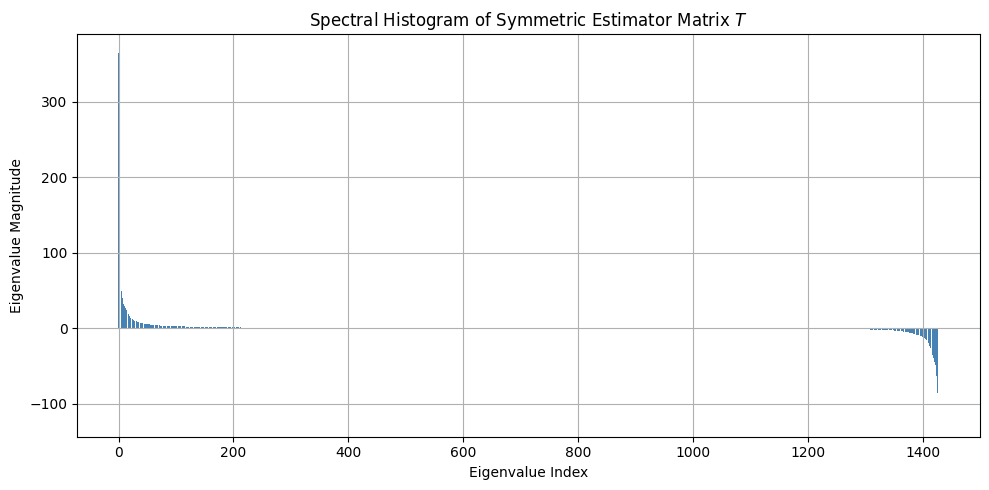

In [9]:
import matplotlib.pyplot as plt


X, y, W_star = generate_data(n, d, p)
T_matrix = build_T_matrix(X, y, d, p)


eigvals, eigvecs = eigh(T_matrix)
eigvals_sorted = np.sort(eigvals)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(eigvals_sorted)), eigvals_sorted, color='steelblue')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue Magnitude')
plt.title('Spectral Histogram of Symmetric Estimator Matrix $T$')
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cuda
L shape: torch.Size([10000, 10000]), L device: cuda:0


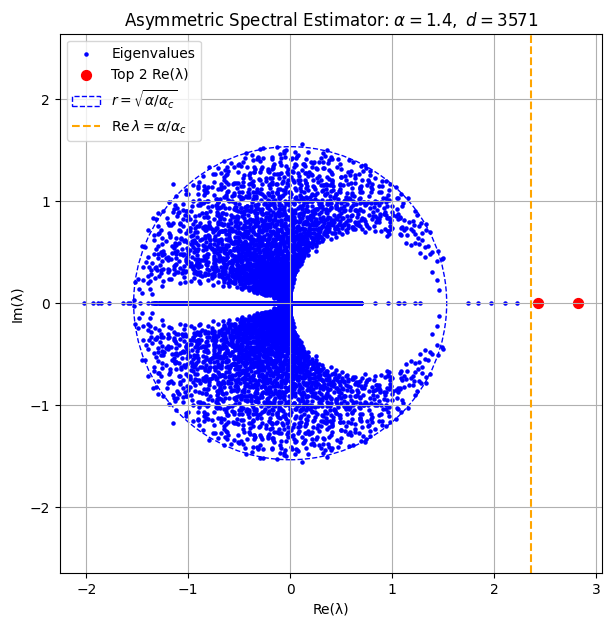

In [10]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# 固定随机种子（可复现性）
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# 配置参数
n = 5000  # 样本数
p = 2      # 子空间维度
alpha = 1.4
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: 生成输入矩阵 X ∈ ℝ^{n × d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Step 2: 构造信号子空间 W* 和观测 Z = X W*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # link function: y = z1 * z2

# Step 3: 计算预处理函数 G(y) ∈ ℝ^{n × p × p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0)-1 
lambda_y[np.isnan(lambda_y)] = 0  # 数值稳定处理

# 构造 G(y): 每个样本一个 2x2 对称矩阵
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Step 4: 构造非对称谱矩阵 L ∈ ℝ^{np × np}
XXT = X @ X.T  # shape: (n, n)
XXT.fill_diagonal_(0.0)  # 去掉主对角线

# 构造谱矩阵 L 的 (iμ, jν) 元素
A = XXT[:, :, None, None]            # shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]     # shape: (1, n, p, p)
L_blocks = A * G_broadcast           # shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)  # shape: (np, np)
print(f"L shape: {L.shape}, L device: {L.device}")

# Step 5: 计算特征值（在 GPU 上）并绘图
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# 获取最大两个实部的特征值索引和特征值
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# 可视化谱图
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# 理论谱圆半径和跳跃阈值
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# 图形设置
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [15]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr

# ==== Step 1: 定义 Generalized Overlap 评估函数 ====
def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')  # 正交化
    X_cpu = X.cpu().numpy().T  # shape: (d, n)

    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # shape: (n, 2)
        U = X_cpu @ V  # shape: (d, 2)

        for j in range(2):
            u = U[:, j]
            u_hat = u / norm(u)
            q = norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

# ==== Step 2: 谱分解与变量准备 ====
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()

# ==== Step 3: 单点 overlap 计算 ====
results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X)

# ==== Step 4: 合并与 DataFrame 构造 ====
all_results = results_red + results_green
df_result = pd.DataFrame(sorted(all_results, key=lambda x: -x[2]),
                         columns=["Label", "Eigenvalue", "Overlap_q"])



print(df_result)



NameError: name 'red_vals' is not defined